In [1]:
%matplotlib inline

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

# Macrostate distribution extrapolation

This notebook demonstrates how to perform temperature extrapolation (or interpolation) of macrostate log-probability distributions $\ln \Pi (N)$ for the number of particles from a flat-histogrammed grand canonical ensemble simulation.

We start by setting up functions to load in the data.

In [2]:
#Need to load in some data, partially specifying information about simulations here
#As well as functions to load data

import glob

def get_sim_activity(Tr):
    if Tr == 0.700:
        return -6.250
    elif Tr == 0.730 or Tr == 0.740:
        return -5.500
    elif Tr == 0.850:
        return -4.800
    elif Tr == 1.100:
        return -3.380
    elif Tr == 1.200:
        return -3.000
    else:
        raise ValueError('Reduced temperature %f outside range in dataset.'%Tr)


def get_file_prefix(Tr, run_num=None):
    base_str = 'notebook_data/lnPi_LJ/lj.t%s.n12m6.v512.rc3.b.r'%(str('%1.2f'%Tr).replace('.', ''))
    if run_num is not None:
        return ['%s%i'%(base_str, run_num)]
    else:
        unstripped = glob.glob('%s*.energy.dat'%base_str)
        return [u[:-11] for u in unstripped]
    

def load_data(Tr, ref_mu=-4.0, run_num=None):
    f_prefixes = get_file_prefix(Tr, run_num=run_num)
    U_moms = np.array([np.loadtxt('%s.energy.dat'%f)[:, 1:] for f in f_prefixes]) #Reduced units of energy/eps
    lnPis = np.array([np.loadtxt('%s.lnpi.dat'%f)[:, 1] for f in f_prefixes])
    N_vals = np.array([np.loadtxt('%s.lnpi.dat'%f)[:, 0] for f in f_prefixes])
    mu = Tr * get_sim_activity(Tr) #Tr is kB*T/eps, activity is mu/kB*T, so getting mu/eps
    
    #Convert to x_arrays with proper labeling
    #Potential energy data is average U and average U^2 at each bin N for each repeat
    #So dimension are N_repeats by N by 2
    #And don't forget to include 0th order moments (all 1s)
    U_moms = np.concatenate([np.ones_like(lnPis)[..., None], U_moms], axis=-1)
    U_moms = xr.DataArray(U_moms, dims=['rec', 'n','umom'])
    #For lnPi, adjust to a reference mu value
    #And subtract off N=0 bin
    lnPis = lnPis + ((1.0/Tr) * (ref_mu - mu) * N_vals) #Multiply by 1/Tr since want beta*mu
    lnPis = lnPis - lnPis[:, :1]
    lnPis = xr.DataArray(lnPis, dims=['rec', 'n'])
    #For mu need to add extra axis called comp
    ref_mu = xr.DataArray(ref_mu*np.ones((len(f_prefixes), 1)), dims=['rec', 'comp'])

    return {'energy': U_moms, 'lnPi': lnPis, 'mu': ref_mu, 'mu_sim': mu, 'beta': 1.0/Tr}


And actually load in the data to use for extrapolation/interpolation. This data is from simulations of in the grand canonical ensemble with flat-histogram methods employed to enhance sampling in the particle number. The potential considered is Lennard-Jones fluid, with more information found at: https://www.nist.gov/mml/csd/chemical-informatics-group/lennard-jones-fluid-properties.

In [3]:
temps = np.array([0.70, 0.73, 0.74, 0.85, 1.10, 1.20])
betas = 1.0 / temps # Reduced temperature is Tr = kB*T/eps, so beta is also dimensionless as eps/kB*T

data_dicts = [load_data(t) for t in temps]

## Extrapolation

We will start out by extrapolating from a central temperature value, moving both higher and lower.

We need to import `thermoextrap` generally for access to data classes, then `xtrap.lnpi` for special functions related to derivatives of macrostate distributions.

In [4]:
import thermoextrap as xtrap

First, we need to create a data object to hold the data. Selecting the data, however, requires a bit of thought. Though we are interested in extrapolating $\ln \Pi (N)$, it turns out it is more convenient (and equivalent within an additive constant) to extrapolate $\ln \Pi (N) - \ln \Pi (0)$. The first two derivatives of this with respect to $\beta = \frac{1}{k_B T}$ are:

&nbsp;&nbsp;&nbsp;&nbsp;$\frac{\mathrm{d} \ln ( \Pi (N)/\Pi(0) )}{\mathrm{d} \beta} = \mu N - \langle U \rangle_N$ <br>
&nbsp;&nbsp;&nbsp;&nbsp;$\frac{\mathrm{d}^2 \ln ( \Pi (N)/\Pi(0) )}{\mathrm{d} \beta^2} = - \frac{\mathrm{d} \langle U \rangle_N}{\mathrm{d} \beta}$ <br>

The chemical potential is given by $\mu$ and the angle brackets with a subscript of $N$ represent a canonical ensemble average at a particular macrostate with $N$ particles. While the first derivative involves $\mu N$ and the potential energy, it is clear that for $k > 1$,

&nbsp;&nbsp;&nbsp;&nbsp;$\frac{\mathrm{d}^k \ln ( \Pi (N)/\Pi(0) )}{\mathrm{d} \beta^k} = - \frac{\mathrm{d}^{k-1} \langle U \rangle_N}{\mathrm{d} \beta^{k-1}}$

What this means is that all we need is a way to compute canonical ensemble derivatives of an average observable with respect to $\beta$, which we have in `xtrap.beta.py`, and a custom derivative function to handle the special case of the 0$^\mathrm{th}$ and 1$^\mathrm{st}$ derivatives. This has been implemented in `xtrap.lnpi.py` for convenience.

Based on the discussion above, we start by creating a custom data callback object that helps manage how derivatives are calculated and what information is provided to the function that calculates the derivatives.

In [5]:
# for lnPi extrapolation, we need to setup a DataCallback
# see definition in xtrap.lnpi
ref = data_dicts[3]
meta_lnpi = xtrap.lnpi.lnPiDataCallback(ref['lnPi'], ref['mu'], dims_n=['n'], dims_comp='comp')

In the above callback, the first argument is the reference $\ln \Pi$ we're extrapolating from, the second argument is the chemical potential $\mu$, `dims_n` is the dimension of the input xarray `DataArray` over which the particle number $N$ changes, and if you really want to understand what `dims_comp` is you'll have to ask Bill.

Next we need a data object to hold the potential energy moments, passing the callback as the `meta` argument. Note that because we're working with potential energies only, we can set `xu=None` and `x_is_u=True` to provide further accelerations for this special case.

In [6]:
data_lnpi = xtrap.DataCentralMoments.from_ave_raw(u=ref['energy'],
                                                   xu=None,
                                                   x_is_u=True,
                                                   central=True,
                                                   meta=meta_lnpi)

And finally, use that data to create our extrapolation model.

In [7]:
em_lnpi = xtrap.lnpi.factory_extrapmodel_lnPi(beta=ref['beta'],
                                             data=data_lnpi,
                                             order=1)

We can make predictions at a range of beta values for which we have data to check (in the loaded "samples" data). Note that we set all $\ln \Pi (0)$ elements to zero.

In [8]:
out_lnpi = em_lnpi.predict(betas).mean(dim='rec')
out_lnpi -= out_lnpi.sel(n=0)

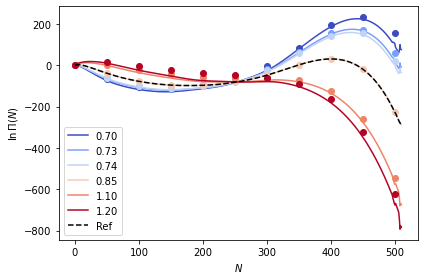

In [9]:
#Plot the results
fig, ax = plt.subplots()

colors = plt.cm.coolwarm(np.linspace(0.0, 1.0, len(betas)))

n_vals = np.arange(out_lnpi.sizes['n'])

for i, b in enumerate(betas):
    ax.plot(n_vals, out_lnpi.sel(beta=b), color=colors[i], label='%1.2f'%temps[i])
    ax.plot(n_vals[::50], data_dicts[i]['lnPi'].mean(dim='rec').values[::50], 'o', color=colors[i])
    
ax.plot(n_vals, ref['lnPi'].mean(dim='rec'), 'k--', label='Ref')

ax.set_xlabel(r'$N$')
ax.set_ylabel('$\ln \Pi (N)$')

ax.legend()

fig.tight_layout()

plt.show()

This extrapolation misses too far away from the reference. Next we will try interpolation using up to first-order derivatives, which gives us a 3rd order interpolating polynomial.

## Interpolation

Implementing interpolation is easy if we already have `Extrap` objects. So just need to build a list of these for the end states (highest and lowest temperatures) we will use as our references.

In [10]:
xems_interp = []
for d in [data_dicts[0], data_dicts[-1]]:
    this_meta = xtrap.lnpi.lnPiDataCallback(d['lnPi'],
                                           d['mu'],
                                           dims_n=['n'],
                                           dims_comp='comp')
    this_data = xtrap.DataCentralMoments.from_ave_raw(u=d['energy'],
                                                       xu=None,
                                                       x_is_u=True,
                                                       central=True,
                                                       meta=this_meta)
    this_xem = xtrap.lnpi.factory_extrapmodel_lnPi(beta=d['beta'],
                                                  data=this_data,
                                                  order=1)
    xems_interp.append(this_xem)
    
xemi = xtrap.InterpModel(xems_interp)

In [11]:
out_xemi = xemi.predict(betas).mean(dim='rec')
out_xemi -= out_xemi.sel(n=0)

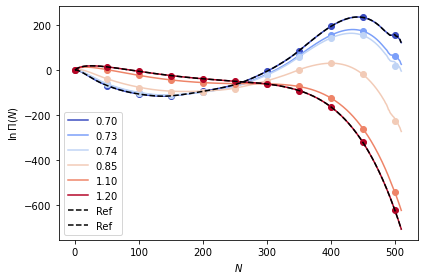

In [12]:
#Plot the results
fig, ax = plt.subplots()

colors = plt.cm.coolwarm(np.linspace(0.0, 1.0, len(betas)))

n_vals = np.arange(out_xemi.sizes['n'])

for i, b in enumerate(betas):
    ax.plot(n_vals, out_xemi.sel(beta=b), color=colors[i], label='%1.2f'%temps[i])
    ax.plot(n_vals[::50], data_dicts[i]['lnPi'].mean(dim='rec').values[::50], 'o', color=colors[i])

for d in [data_dicts[0], data_dicts[-1]]:
    ax.plot(n_vals, d['lnPi'].mean(dim='rec'), 'k--', label='Ref')

ax.set_xlabel(r'$N$')
ax.set_ylabel('$\ln \Pi (N)$')

ax.legend()

fig.tight_layout()

plt.show()

Interpolation is definitely an improvement while using first-order derivatives, though it comes at the cost of a second simulation.